## Run, Don't Read

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import torch
import gc

from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizer

print('# of gpus: ', torch.cuda.device_count())

import pandas as pd
import json
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt

from logger_config import logger
from Pruning.FLAP.lib.prune import prune_flap_modular, CIRCUIT_from_scores, head_wise_pruning_scores
from Pruning.FLAP.lib.FLAP import hybrid_FLAP
from circuits.circuits_PP import get_circuit_name, choose_PP_circuit
from Pruning.FLAP.lib.parser import parser

from dataset.loader import load_dataset
from utils.data_io import save_img, create_folder, save_parser_information, save_circuit, store_df, set_PATH
from utils.metrics import ave_logit_diff
from utils.visualization import heat_map_pruning
from utils.model_loader import get_gpt2_adapt_to_llama, load_tokenizer, load_hooked_transformer, load_transformer
from utils.dataset_loader import predict_target_token
from utils.eval_circuit import evaluate_circiut, print_statistics

# of gpus:  1


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# 1. One Run Through FLAP and Evaluation

### Parser

In [6]:
is_notebook = get_ipython()
ipython =  is_notebook is not None

if ipython:
    input_args = [
        
        # ----- model names ------
        #'--model_name=baffo32/decapoda-research-llama-7B-hf',
        '--model_name=gpt2',
        #'--model_name=gpt2',
        #"--model_name=Qwen/Qwen2.5-0.5B",
    
        # ----- FLAP parameters
        '--nsamples=50',  
        '--pruning_ratio=0.68',
        '--remove_heads=134', 
        
        '--metrics=WIFN', 
        '--structure=AL-AM',
        
        "--difference_with=corrupted",

        
        # ---- task ------
        #'--task=GreaterThan',
        '--task=IOI',
        #'--task=GenderedPronouns',
        #'--task=Induction',
        #'--task=Docstring',
        
        # ---- others
        '--seed=239501',
        '--device=cuda',

        # ----- save and plot -----
        "--show",
        #"--save_img",
        #"--save_txt", 
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights'",
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final",

    ]


args = parser.parse_args(input_args)

# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)


result_folder = f"{args.model_name}/{args.task}/FLAP/{args.metrics}/{args.difference_with}/"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = args.out_path + result_folder

create_folder(subfolder)

# set path variables:
set_PATH(args.out_path)


### Average Logits of Unpruned model and GT circuit

In [15]:
torch.cuda.empty_cache()
gc.collect()

# ---- loading model, tokenizer, dataset and GT circuit -----
model_hooked = load_hooked_transformer(args.model_name, device=args.device, cache_dir=args.cache_dir)  
eval_tokenizer = load_tokenizer(args.model_name)           
eval_dataset = load_dataset(
    model_name=args.model_name,
    prepend_bos=args.prepend_bos, 
    task=args.task, 
    tokenizer=eval_tokenizer, 
    N=200,#args.nsamples, 
    device=args.device, 
    seed=193485603,#args.seed+10,
)


print("test that the right token is predicted by the unpruned model under clean distribution")
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)
print("test that the right token is predicted by the unpruned model under corrupted distribution")
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1,use_corrupted=True)

# ---- Average Logits of Unpruned model -----
with torch.no_grad():
    hooked_gt = model_hooked(eval_dataset.clean_tokens)
    
ave_logit_gt = ave_logit_diff(
    hooked_gt, 
    eval_dataset.correct_answers,
    eval_dataset.wrong_answers,   
    eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )
    
res_unpruned_model = f"Average logit unpruned model: {ave_logit_gt} \n \n"
print(res_unpruned_model)

gt_circuit_name =  get_circuit_name(args.task)

try:
    GT_CIRCUIT = choose_PP_circuit(args.task, args.model_name)
except:
    GT_CIRCUIT={}

# ----- Average Logits of the GT circuit ------
gt_circuit_ave_logit, gt_circuit_performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=GT_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt, 
    task=args.task, 
    model_name=args.model_name
    )

res_ground_truth = print_statistics(
    title=f"*********** GT Circuit of {gt_circuit_name} Task **************",
    ave_logit=gt_circuit_ave_logit, 
    performance_achieved=gt_circuit_performance,
    CIRCUIT=GT_CIRCUIT, 
    IOI_CIRCUIT=GT_CIRCUIT
    )
print(res_ground_truth)

# ----- saving ------
if args.save_txt:
    with open(subfolder + "ground_truth.txt", "w") as file:
        file.write(res_unpruned_model)
        file.write(res_ground_truth)


loading gpt2 as HookedTransformer
use float 16


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
load gpt2 tokenizer
using gpt2 model in IOI dataset
test that the right token is predicted by the unpruned model under clean distribution
Top 10 Predictions
Prompt 0 : Then, Graham and Kate were thinking about going to the office. Graham wanted to give a bone to Kate
 the       | Probability: 0.2389
 Kate      | Probability: 0.0826
 her       | Probability: 0.0604
 his       | Probability: 0.0344
 their     | Probability: 0.0237
 a         | Probability: 0.0143
 Graham    | Probability: 0.0135
 them      | Probability: 0.0127
 someone   | Probability: 0.0099
 those     | Probability: 0.0087


test that the right token is predicted by the unpruned model under corrupted distribution
Top 10 Predictions
Prompt 0 : Then, Rachel and Clark were thinking about going to the office. Alice wanted to give a bone to Kate
 Rachel    | Probability: 0.1826
 the       | Probability: 0.1514
 her       | Probability: 0.0761

### run FLAP

load gpt2 as CasualLLM adapted to the Llama architecture


GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

load gpt2 tokenizer
using gpt2 model in IOI dataset


Processing layers: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.53it/s]



 
*********** Patching Circuit of IOI Circuit Task **************
Average logit difference: 2.5410 
circuit size: 45 
performance achieved: 84.48% 
TPR: 0.00% 
FPR: 100.00% 
Precision: 0.00% 



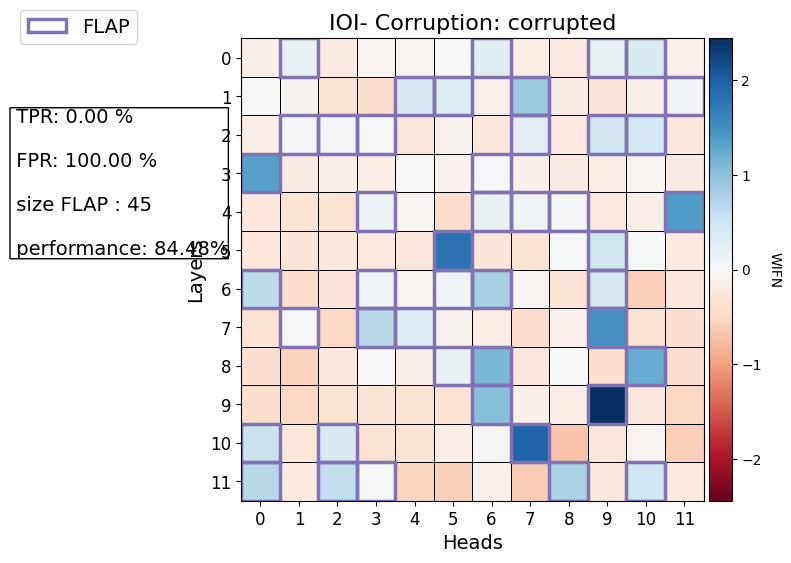

In [20]:
GT_CIRCUIT={}
# Run FLAP
torch.cuda.empty_cache()
gc.collect()

if "gpt2" in args.model_name:
    model = get_gpt2_adapt_to_llama(args.model_name, args.device)
elif "Qwen" in args.model_name:
    model = load_transformer(args.model_name, args.device, cache_dir=args.cache_dir)
tokenizer = load_tokenizer(args.model_name)
  


# ---- run FLAP ------
CIRCUIT, scores, GFLOPS, n_traversed_layers= prune_flap_modular(args, model, tokenizer)
# ----- Evaluate - compare to unpruned model ------
ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,    
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt, 
    task=args.task,
    model_name=args.model_name
    )

#gain = performance_gain(performance_new=performance, performance_old=gt_circuit_performance)


res = print_statistics(
    title=f"*********** Patching Circuit of {gt_circuit_name} Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=GT_CIRCUIT
    )
print(res)
        
fig = heat_map_pruning(
    scores, 
    GT_CIRCUIT=GT_CIRCUIT,
    PRUNING_CIRCUIT=CIRCUIT, 
    title=f"{args.task}- Corruption: {args.difference_with}",
    title_pruning_circuit="FLAP",
    title_gt_circuit="Path Patching",
    performance=performance,
    print_scores=False,
    title_temp_scale=args.metrics, 
    print_text=True
    )

# 2. Hybrid FLAP

In [ ]:
torch.cuda.empty_cache()
gc.collect()
# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)

#################### Parser #####################################

is_notebook = get_ipython()
ipython =  is_notebook is not None

if ipython:
    input_args = [
        # ----- models ------
        #'--model_name=gpt2-large',
        #"--model_name=Qwen/Qwen2.5-7B",
        #"--model_name=Qwen/Qwen2.5-0.5B",
        '--model_name=gpt2',
          
        # ----- cliff points ------
        "--step_size=1",
        "--lowest_sparsity=80", 
        "--highest_sparsity=99",
        "--cliff_point=biggest",        
        
                
        '--seed=239501',
        '--nsamples=10',  
        '--batch_size=10',
        
        # ----- tasks ------
        #'--task=GreaterThan',
        '--task=IOI',
        #'--task=GenderedPronouns',
        #'--task=Induction',
        #"--task=Docstring",
        
        '--device=cuda',
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final/",
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights/",

        "--show",
        "--save_image", 
        "--save_txt",
        "--calc_FLOP", 
        "--verbose",

    ]


args = parser.parse_args(input_args)
set_PATH(args.out_path)

load gpt2 as CasualLLM adapted to the Llama architecture


GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

load gpt2 tokenizer
using gpt2 model in IOI dataset


 ... (more hidden) ...


using gpt2 model in IOI dataset


 ... (more hidden) ...


loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
using gpt2 model in IOI dataset


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.1.hook_q_input, blocks.1.hook_resid_mid, blocks.1.hook_resid_post, blocks.1.hook_resid_pre, blocks.1.hook_v_input, blocks.1.ln1.hook_n


 
*********** GT Circuit of IOI Circuit Task **************
Average logit difference: 0.6689 
circuit size: 0 
performance achieved: 23.69% 
TPR: 0.00% 
FPR: 0.00% 
Precision: 0.00% 

sparsity_ratio: 0.8, ave_logit_diff: 1.974609375, performance: 69.91701244813278, gain 195.18248175182484, diff: -1.3056640625, TPR:0


/mnt/lustre/home/eickhoff/esx670/AcceleratedPathPatching/Pruning/FLAP/lib/FLAP.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


sparsity_ratio: 0.81, ave_logit_diff: 2.046875, performance: 72.47579529737206, gain 205.98540145985402, diff: -0.072265625, TPR:0
sparsity_ratio: 0.82, ave_logit_diff: 2.037109375, performance: 72.13001383125865, gain 204.52554744525554, diff: 0.009765625, TPR:0
sparsity_ratio: 0.83, ave_logit_diff: 2.02734375, performance: 71.78423236514523, gain 203.06569343065698, diff: 0.009765625, TPR:0
sparsity_ratio: 0.84, ave_logit_diff: 2.04296875, performance: 72.3374827109267, gain 205.40145985401463, diff: -0.015625, TPR:0
sparsity_ratio: 0.85, ave_logit_diff: 2.056640625, performance: 72.82157676348548, gain 207.44525547445258, diff: -0.013671875, TPR:0
sparsity_ratio: 0.86, ave_logit_diff: 1.9970703125, performance: 70.71230982019364, gain 198.5401459854015, diff: 0.0595703125, TPR:0
sparsity_ratio: 0.87, ave_logit_diff: 2.052734375, performance: 72.68326417704012, gain 206.8613138686132, diff: -0.0556640625, TPR:0
sparsity_ratio: 0.88, ave_logit_diff: 2.01171875, performance: 71.2309820

/mnt/lustre/home/eickhoff/esx670/AcceleratedPathPatching/Pruning/FLAP/lib/FLAP.py:188: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


sparsity_ratio: 0.81, ave_logit_diff: 0.7529296875, performance: 26.659751037344407, gain 12.554744525547493, diff: 0.8037109375, TPR:0
sparsity_ratio: 0.82, ave_logit_diff: 0.75, performance: 26.556016597510364, gain 12.116788321167856, diff: 0.0029296875, TPR:0
sparsity_ratio: 0.83, ave_logit_diff: 0.6904296875, performance: 24.446749654218536, gain 3.211678832116807, diff: 0.0595703125, TPR:0
sparsity_ratio: 0.84, ave_logit_diff: 0.69384765625, performance: 24.567773167358226, gain 3.722627737226272, diff: -0.00341796875, TPR:0
sparsity_ratio: 0.85, ave_logit_diff: 0.68115234375, performance: 24.11825726141079, gain 1.8248175182481914, diff: 0.0126953125, TPR:0
sparsity_ratio: 0.86, ave_logit_diff: 0.45947265625, performance: 16.269017980636235, gain -31.31386861313869, diff: 0.2216796875, TPR:0
sparsity_ratio: 0.87, ave_logit_diff: 0.35009765625, performance: 12.396265560165972, gain -47.664233576642346, diff: 0.109375, TPR:0
sparsity_ratio: 0.88, ave_logit_diff: 0.262451171875, pe

GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

INIT_FLOPS 220.611059712
INIT COMP TIME 14.519788026809692
INIT_COMP_TIME 14.519788026809692
cliff biggest from 80 to 99
window 2
clean thresholds
drop_threshold 4.483056708160443
slope_threshold -0.09661134163208851
DataFrame saved as clean_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/IOI/Pruning/biggest/sparsity-min_80/
Figure(900x600)
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/IOI/Pruning/biggest/sparsity-min_80/clean_ROC
cliff at 0.94
using gpt2 model in IOI dataset


 ... (more hidden) ...



 
*********** FLAP Circuit vs GT Circuit **************
Average logit difference: 1.2031 
circuit size: 8 
performance achieved: 42.60% 
TPR: 0.00% 
FPR: 100.00% 
Precision: 0.00% 
performance gain 79.85% 
 



<string>:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/IOI/Pruning/biggest/sparsity-min_80/clean_heatmap.png
FLOPS after clean 1027.717788672
elapsed time for clean loop 0.7121889591217041
corrupted thresholds
drop_threshold 6.219744121715076
slope_threshold -0.4439488243430151
DataFrame saved as ablated_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/IOI/Pruning/biggest/sparsity-min_80/
(19,)
(19,)


ValueError: x and y must have same first dimension, but have shapes (19,) and (1,)

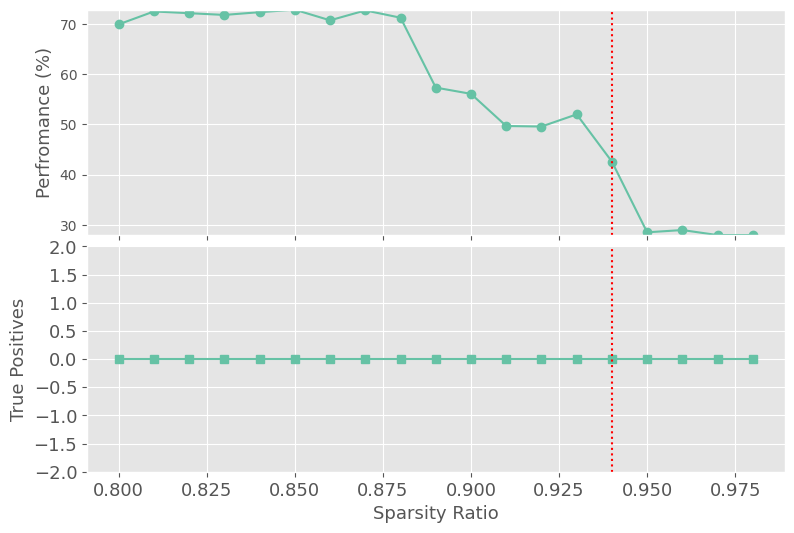

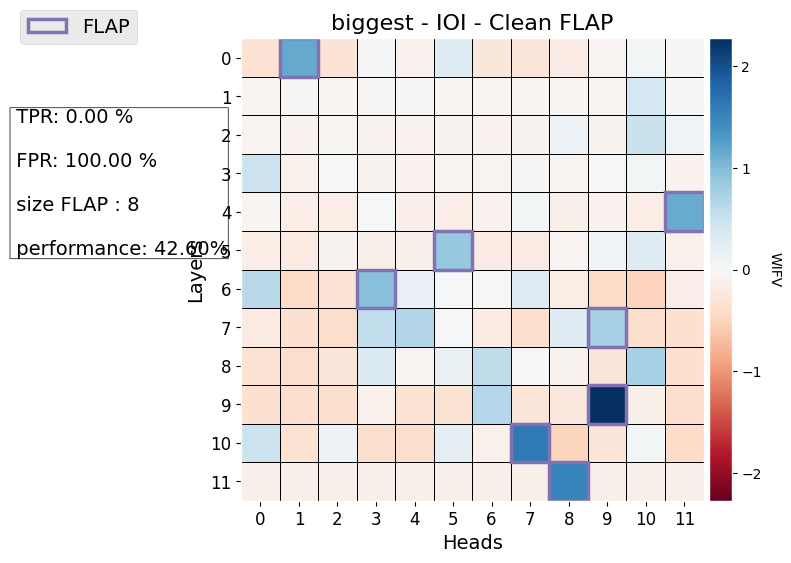

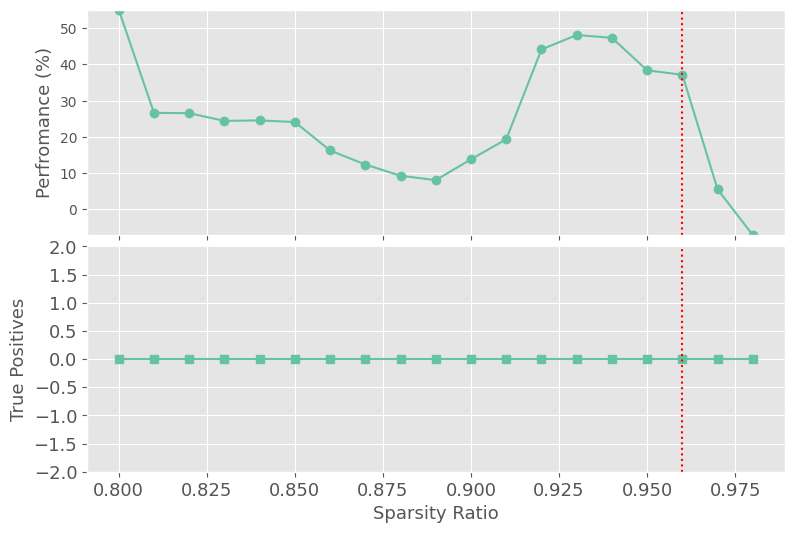

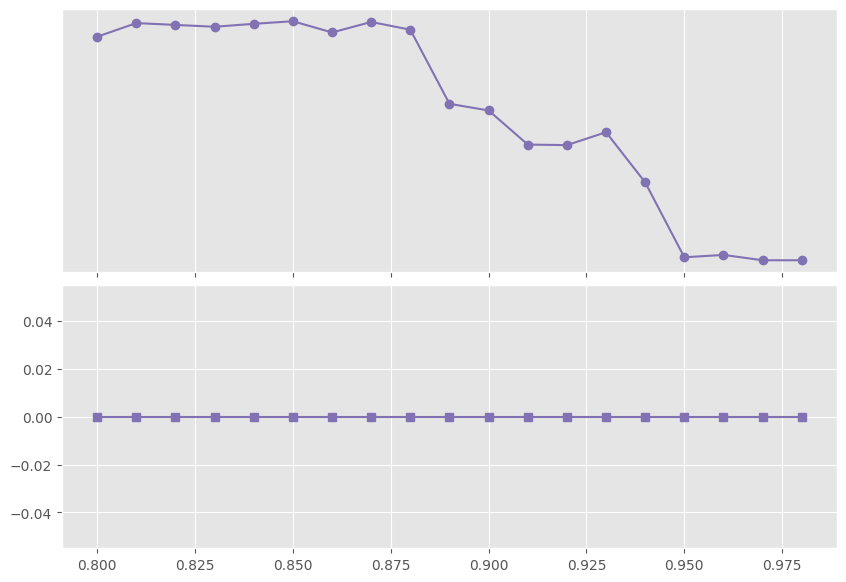

In [12]:
hybrid_FLAP(
    args=args,
    half_life_metric=False,
    )

# TODO: delte

## Plot 

In [ ]:
from utils.utils import load_df, read_df
from utils.Visualization import two_ROC_curve
corr_data = read_df(f"/mnt/lustre/work/eickhoff/esx670/res_final/{args.model_name}/{args.task}/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99", "ablated_table.xlsx")
clean_data = read_df(f"/mnt/lustre/work/eickhoff/esx670/res_final/{args.model_name}/{args.task}/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99", "clean_table.xlsx")

two_ROC_curve(corr_data, corr_data["performance"], None, clean_data, clean_data["performance"], None, "", p1=None, p2=None)

In [ ]:
from Pruning.FLAP.lib.FLAP_largeModels import first_cliff, biggest_cliff
corr_data = read_df("/mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/induction/Pruning/first/sparsity-min_60/", "clean_table.xlsx")

y_variable = "performance"
results_corr_loop = corr_data[(corr_data["sparsity_ratio"] >= 60 / 100) & (corr_data["sparsity_ratio"] < 99 / 100)]
performance_metric = results_corr_loop[y_variable].tolist()



window=round((99-60) / 10)
average_window = window

max_diff = max(results_corr_loop[y_variable]) - min(results_corr_loop[y_variable])
print(max_diff)

drop_threshold=max_diff / 10 #(max_diff/250) * 0.5 -((10-average_window)/100)
print("drop threshold", drop_threshold)
slope_threshold=-drop_threshold
cliff_idx = first_cliff(performance_metric, window=window, drop_threshold=drop_threshold)

if cliff_idx==-1:
    corr_cliff = 0.75
else:
    corr_cliff = results_corr_loop["sparsity_ratio"].iloc[cliff_idx]
fig1 = ROC_curve(results_corr_loop, performance_metric, cliff_value=corr_cliff, title=f"First Drop")



cliff_idx = biggest_cliff(performance_metric, window=window, drop_threshold=drop_threshold)

if cliff_idx==-1:
    corr_cliff = 0.75
else:
    corr_cliff = results_corr_loop["sparsity_ratio"].iloc[cliff_idx]
fig1 = ROC_curve(results_corr_loop, performance_metric, cliff_value=corr_cliff, title=f"Biggest Drop")


## redownload corrupted files

In [ ]:
from transformers import AutoTokenizer

for use_fast in (True, False):
    try:
        print("Trying use_fast=", use_fast)
        tok = AutoTokenizer.from_pretrained("gpt2", use_fast=use_fast)
        print("Loaded tokenizer OK, pad_token:", tok.pad_token, "eos:", tok.eos_token)
    except Exception as e:
        print("Error with use_fast=", use_fast, "->", repr(e))


In [27]:
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained(
    "gpt2",
    force_download=True,
    cache_dir=None,  # optional, but helps rebuild fresh
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

# Look at Attention Pattern

In [9]:
from circuits_PP import IOI_CIRCUIT, choose_circuit, get_manual_PP_circuit
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/Subtracted_FLAP"
args.task = "ioi"
CIRCUIT = choose_circuit(args.task, args.model_name)

path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_2.5/


In [50]:
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/SubtractedFLAP"


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
using gpt2 model in IOI dataset
from 0 to 21
torch.Size([1, 12, 21, 21])


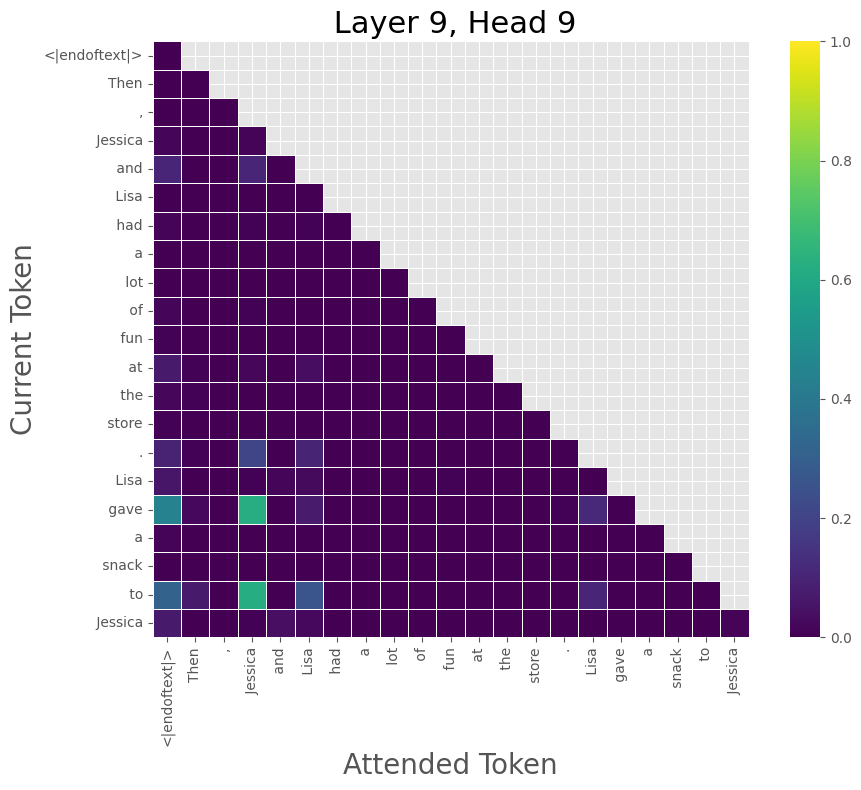

In [60]:
from utils.utils import activation_patterns

tokenizer = load_tokenizer(args.model_name)
args.device="cuda"
model = load_transformer(args.model_name, output_attentions=True, device=args.device, cache_dir=args.cache_dir)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
args.task, 
tokenizer,
N =1, 
seed=123443,#args.seed, 
device=args.device, 
model_name=args.model_name, 
prepend_bos=True, 
remove_target_token=False
)

CIRCUIT={9:[9]}
# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT,
    activation_type="difference", #"clean", "corrupted", "difference"
    save=False,
    show=True,
    out_path=save_path,
    title=""


) #layer_list=[14] , head_list=[3], is_corrupted=True)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
Load GreaterThan with gpt2
from 0 to 14
create new path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/0_1.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/0_5.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/5_1.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/5_5.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/6_9.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/7_10.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activati

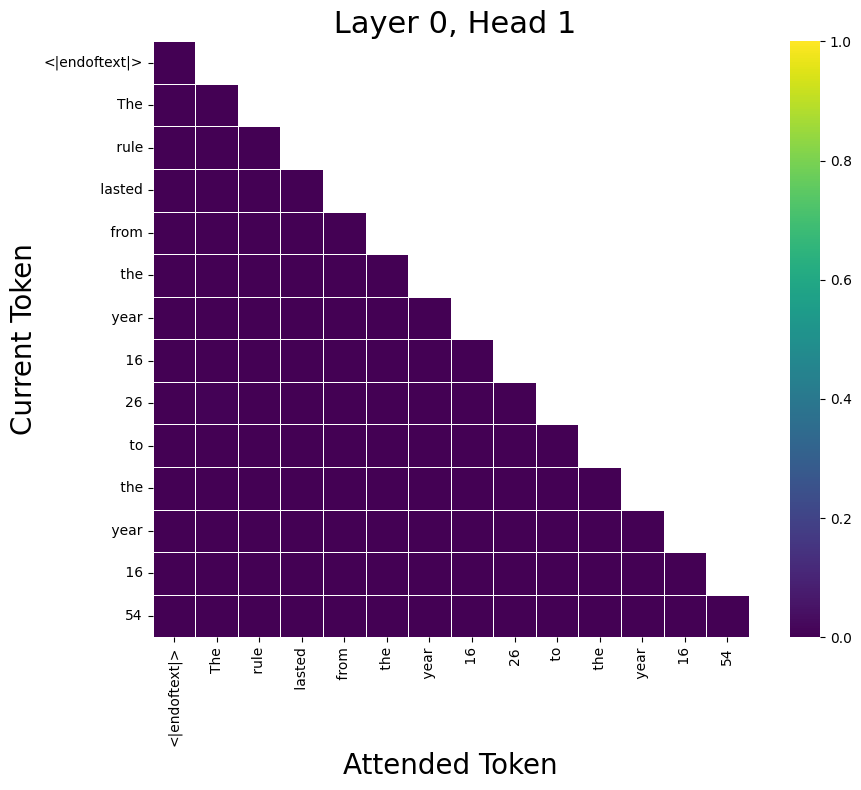

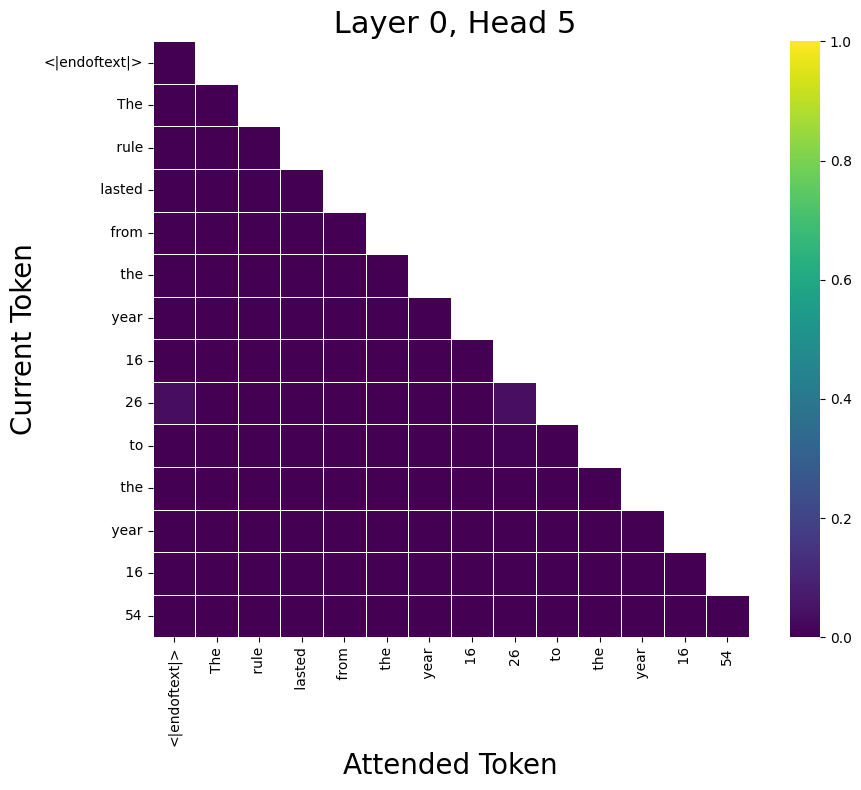

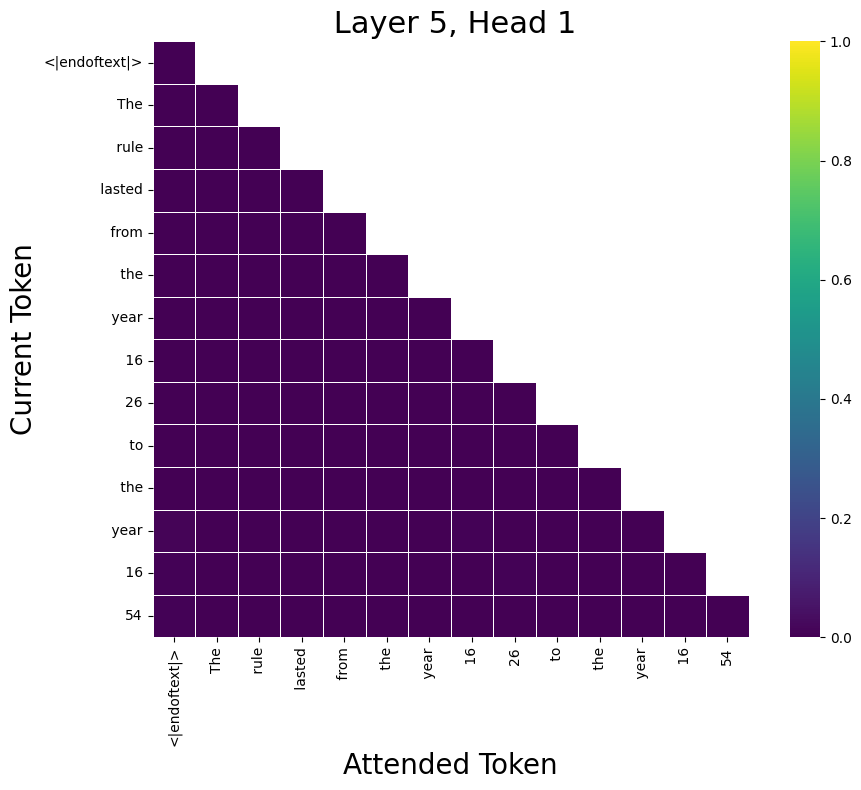

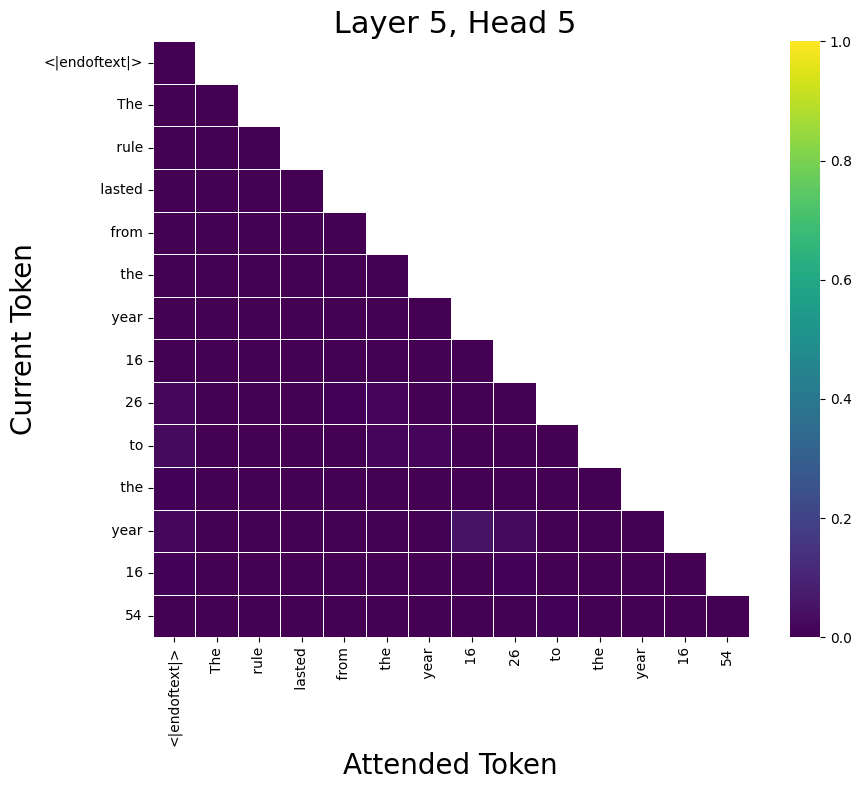

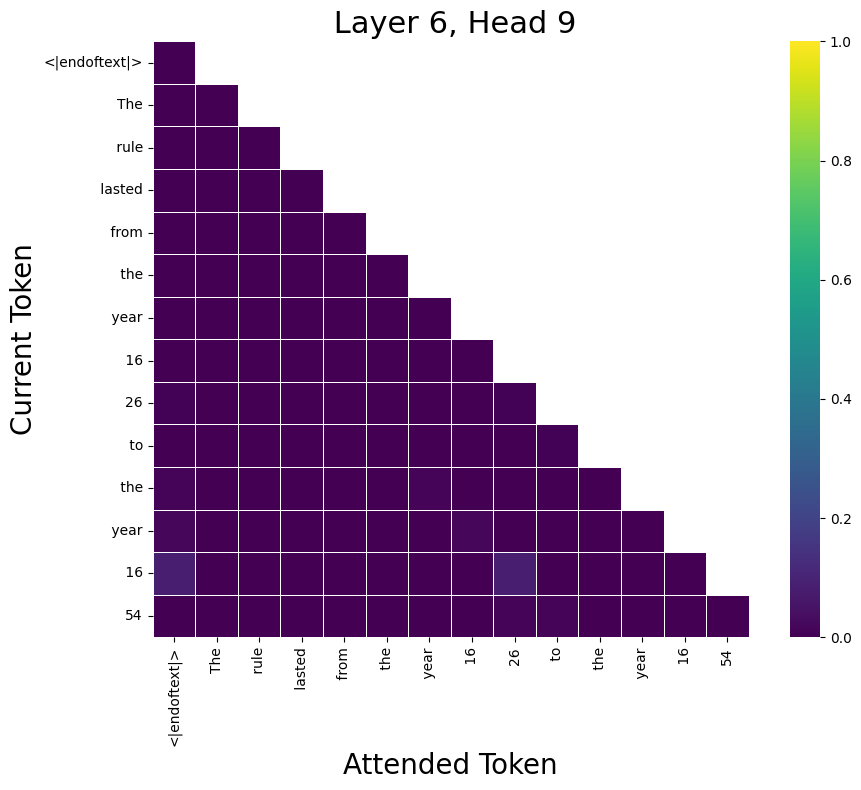

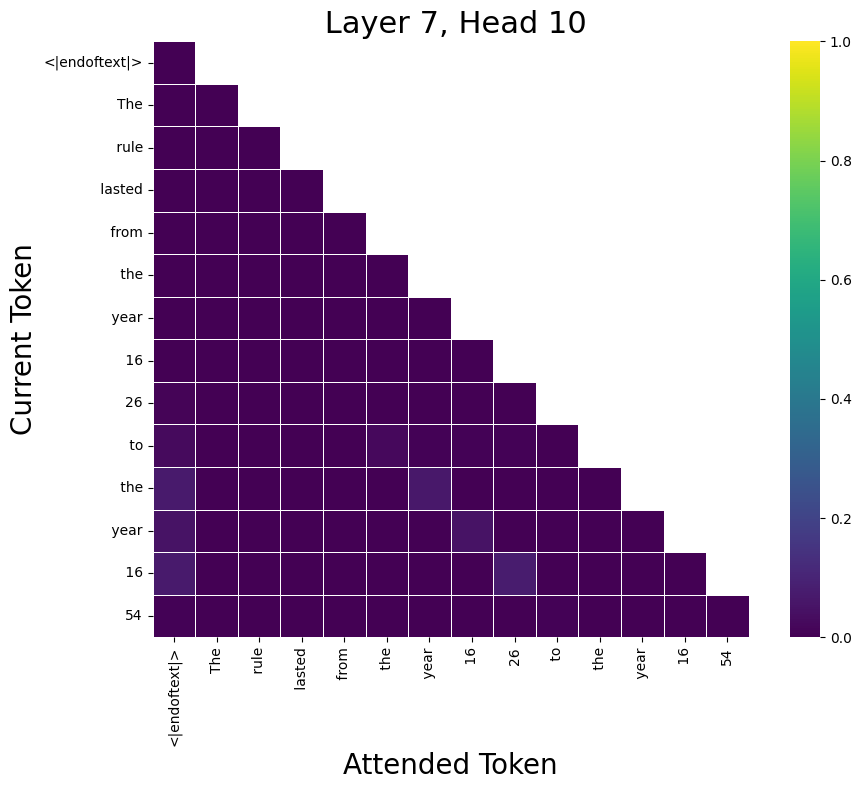

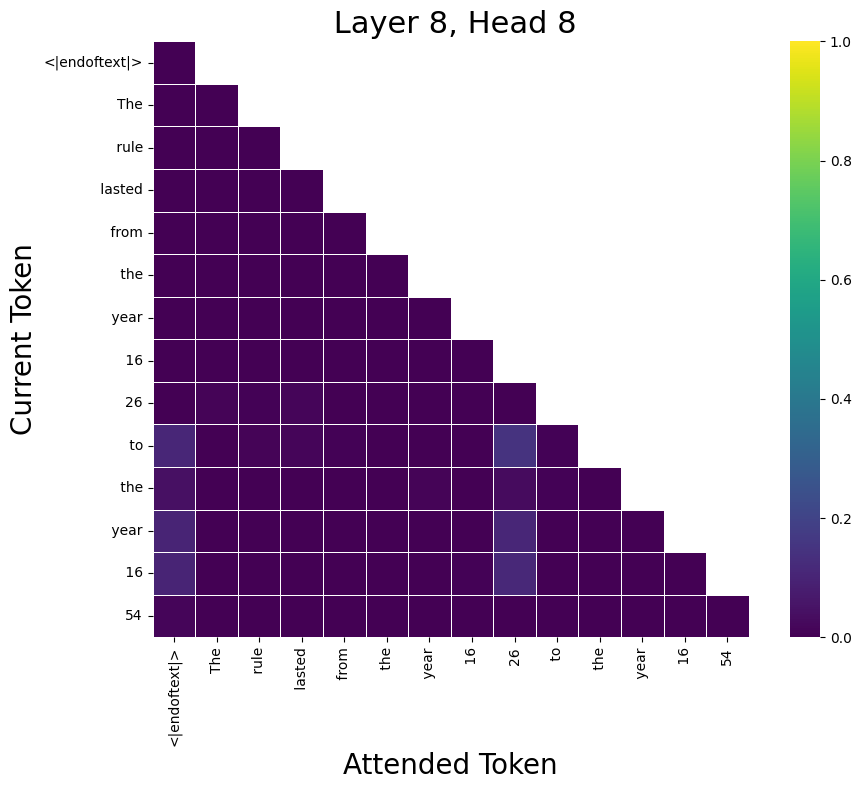

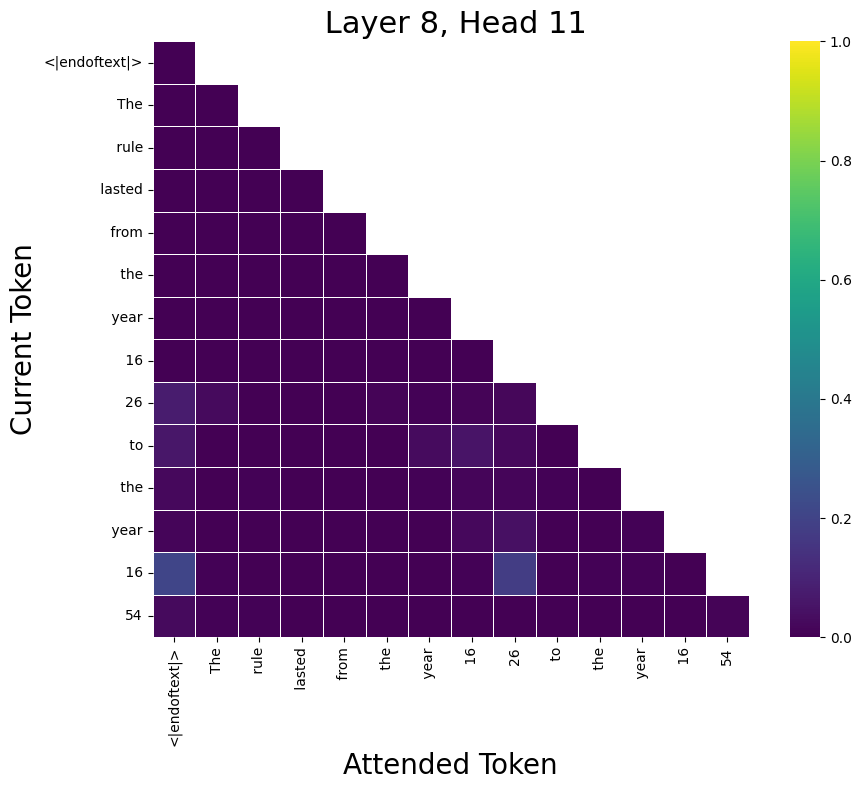

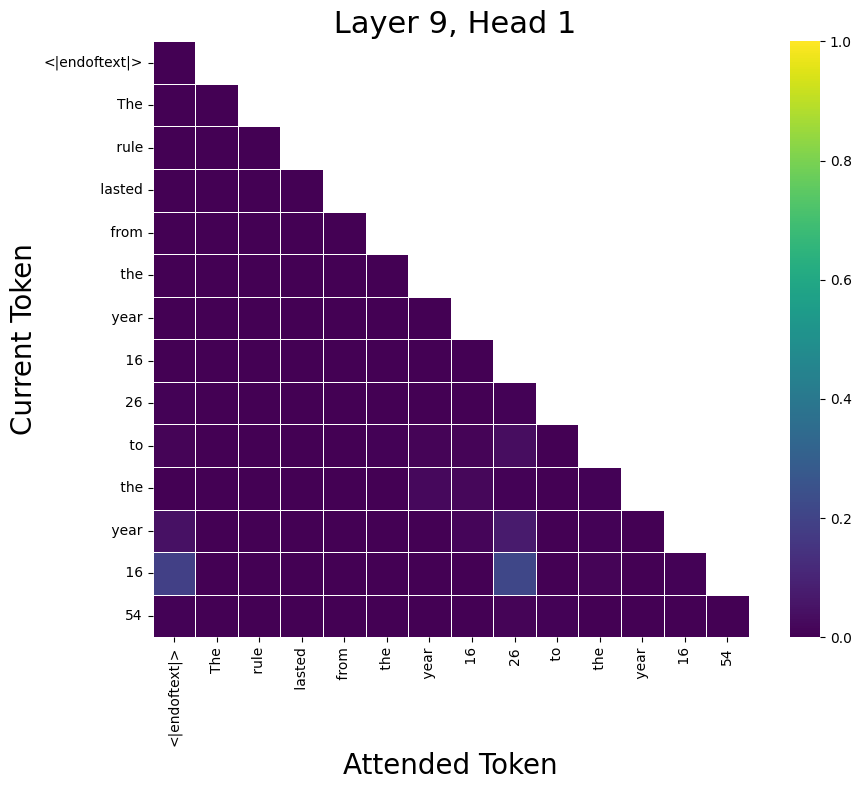

In [ ]:
from utils.utils import activation_patterns
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/Path_Patching"
CIRCUIT_ORIG = choose_circuit(args.task, args.model_name)
tokenizer = load_tokenizer(args.model_name)

model = load_transformer(args.model_name, output_attentions=True, device=args.device, cache_dir=args.cache_dir)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
    args.task, 
    tokenizer,
    N =1, 
    seed=1233443,#args.seed, 
    device=args.device, 
    model_name=args.model_name, 
    prepend_bos=True, 
    remove_target_token=False
)


# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_type = "contrastive" #clean "corrupted", "contrastive"
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT_ORIG,
    activation_type=activation_type,
    save=True,
    show=True,
    out_path=f"{args.out_path}/{args.model_name}/{args.task}/activations/{activation_type}",
    title=""
    
    
    ) #layer_list=[14] , head_list=[3], is_corrupted=True)